# Readout Calibration of QuFEM on Real Quantum Device 
**Author:** Hanyu Zhang & Siwei Tan

**Date:** 9/4/2024

Based on paper "[QuFEM: Fast and Accurate Quantum Readout Calibration Using the Finite Element Method][1]" (ASPLOS 2024)

[1]: https://dl.acm.org/doi/10.1145/3620665.3640380

<div style="text-align:center;">
    <img src="../picture/4_2_topology.jpg"  width="30%" height="30%">
</div>

The fidelity of reading each quantum bit is as shown in the figure above.
We run a GHZ circuit on the QuaFu[<sup>[7]</sup>](#R7) quantum computer and load its data. 
The device is a 136-qubit device, with 131 available qubits. The basic gates supported are single-qubit gates (ID, RX, RY, RZ, H) and two-qubit gates (CX). The fidelity of single-qubit gates and two-qubit gates are $94.6 \pm 3.1$% and $94.6 \pm 3.0$% respectively.


In [1]:
import os
os.chdir("..")
import sys
sys.path.append('..')
import logging
logging.basicConfig(level=logging.WARN)

from time import time
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info.analysis import hellinger_fidelity

from janusq.optimizations.readout_mitigation.fem import Mitigator
from janusq.optimizations.readout_mitigation.fem.tools import npformat_to_statuscnt,downsample

We fist load the dataset for the notebook.

In [2]:
from janusq.dataset import matrices_ibu, ghz_error, benchmark_circuits_and_results

ghz_output = ghz_error

ibu_matrices = matrices_ibu

Traceback (most recent call last):
  File "/Users/chutianyao/Data/Quantum Technology and Device/Tutorial/HPCA 2025/JanusQ/janusq/dataset/__init__.py", line 15, in <module>
    real_qc_5bit = pickle.load(f)
_pickle.UnpicklingError: invalid load key, 'v'.


## QuFEM

80it [00:19,  4.15it/s]


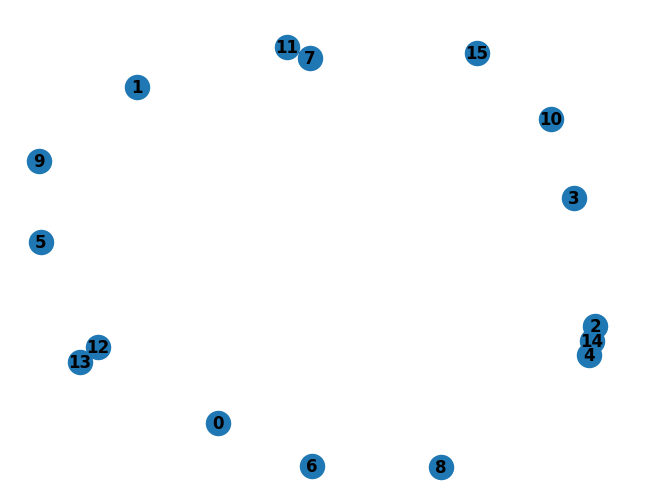

80it [00:11,  6.71it/s]


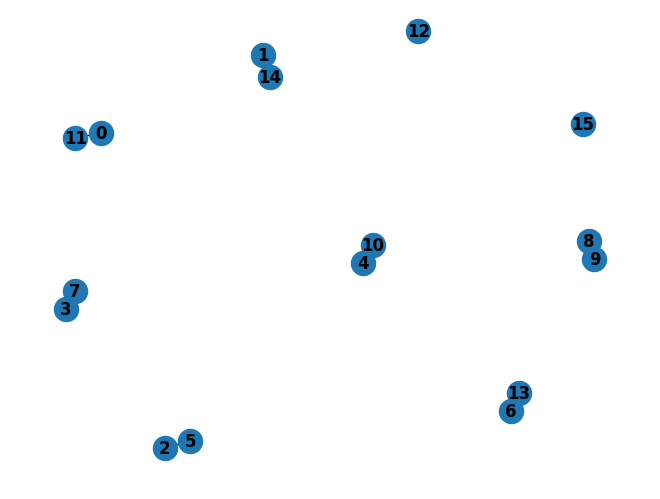

In [3]:
samples = 10000
qubits = 16

benchmark_circuits_and_results = downsample(benchmark_circuits_and_results,[i for i in range(qubits)])
bstrs = []
protocol_statuscnts = []

for key, value in benchmark_circuits_and_results.items():
    bstrs.append(np.array(list(key), dtype=np.int8))
    protocol_statuscnts.append(value)

mitigator = Mitigator(qubits, n_iters = 2)
scores = mitigator.init((bstrs, protocol_statuscnts), group_size = 2, partation_methods=[
                         'max-cut'],multi_process=False, draw_grouping = True)

In [4]:
# Calibrate GHZ
t_qufem_new = []
qufem_fid = []


for i in range(len(ghz_output)):
    n_qubits = 6+i*2

    outout_ideal = {'1'*n_qubits:samples*0.5,'0'*n_qubits:samples*0.5}
    
    t_qufem_1_new = time()
    output_fem = mitigator.mitigate(ghz_output[i],[i for i in range(n_qubits)], cho = 1 )
    t_qufem_2_new = time()
    output_fem = npformat_to_statuscnt(output_fem)

    t_qufem_new.append(t_qufem_2_new-t_qufem_1_new)
    qufem_fid.append(hellinger_fidelity(outout_ideal,output_fem))

## Comparison to IBU

We have collected 5-qubit to 131-qubit GHZ circuit output on a 136-qubit quantum device. We compare the calibration accuracy and overhead of QuCT to IBU[<sup>[4]</sup>](#R4).

In [5]:
un_fid = []
for i in range(len(ghz_output)):
    n_qubits = 6+i*2
    ghz_noisy = ghz_output[i]
    outout_ideal = {'1'*n_qubits:samples*0.5,'0'*n_qubits:samples*0.5}
    un_fid.append(hellinger_fidelity(ghz_noisy,outout_ideal))

In [6]:
# construct the IBU mitigator and apply calibration
from janusq.baselines.readout_calibration.IBU.src.IBU import IBU
from janusq.baselines.readout_calibration.IBU.utils.qc_utils import *
from janusq.baselines.readout_calibration.IBU.utils.data_utils import *

t_ibu_new = []
ibu_fid = []
for i in range(len(ghz_output)):
    n_qubits = 6+i*2
    params = {
        "exp_name": "ghz",
        "method": "reduced",  
        "library": "jax",  
        "num_qubits": n_qubits,
        "max_iters": 1000,
        "tol": 1e-5,
        "use_log": False,  
        "verbose": True,
        "init": "unif",  
        "smoothing": 1e-8,
        "ham_dist": 3
    }

    matrices_ibu = ibu_matrices[:n_qubits]
    outout_ideal = {'1'*n_qubits:samples*0.5,'0'*n_qubits:samples*0.5}


    ibu_new = IBU(matrices_ibu, params)
    ghz_noisy = ghz_output[i]
    ibu_new.set_obs(dict(ghz_noisy))
    t_ibu_new_1 = time()
    ibu_new.initialize_guess()
    t_sol_new, max_iters_new, tracker_new = ibu_new.train(params["max_iters"], tol=params["tol"], soln=outout_ideal)
    t_ibu_new_2 = time()
    outout_ibu_new = ibu_new.guess_as_dict()

    t_ibu_new.append(t_ibu_new_2-t_ibu_new_1)
    ibu_fid.append(hellinger_fidelity(outout_ideal,outout_ibu_new).item())

IBU Iteration:   7%|▋         | 66/1000 [00:18<04:21,  3.58it/s]


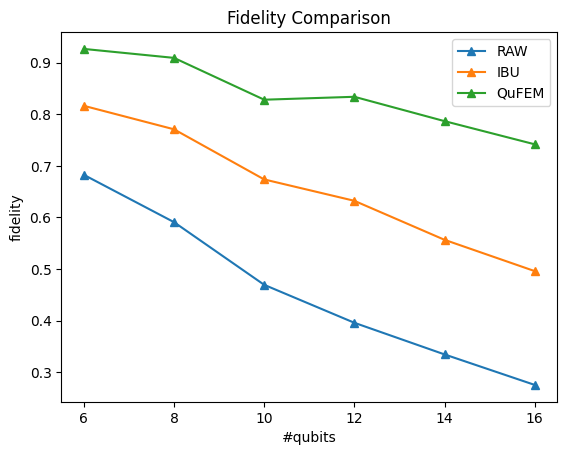

In [7]:
# compare the fidelity improvement

x = [6+i*2 for i in range(len(ghz_output))]

plt.plot(x, un_fid, label='RAW', marker='^', linestyle='-')
plt.plot(x, ibu_fid, label='IBU', marker='^', linestyle='-')
plt.plot(x, qufem_fid, label='QuFEM', marker='^', linestyle='-')
plt.xticks(x) 
plt.title('Fidelity Comparison')
plt.xlabel('#qubits')
plt.ylabel('fidelity')

plt.legend()

plt.show()

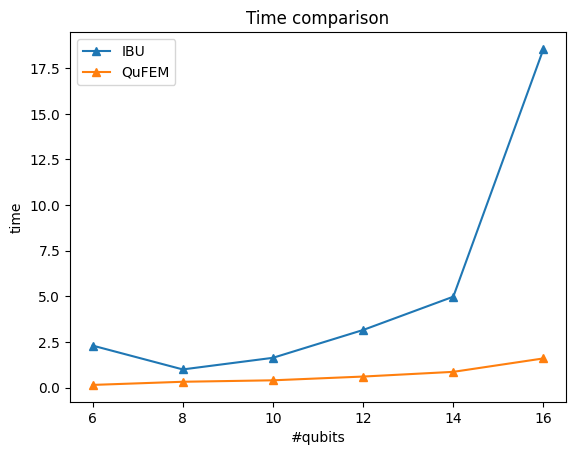

In [8]:
# compare the time cost
x = [6+i*2 for i in range(len(ghz_output))]

plt.plot(x, t_ibu_new, label='IBU', marker='^', linestyle='-')
plt.plot(x, t_qufem_new, label='QuFEM', marker='^', linestyle='-')
plt.xticks(x) 
plt.title('Time comparison')
plt.xlabel('#qubits')
plt.ylabel('time')

plt.legend()
plt.show()

**References**



<div><a name="R1"></a>
[1] Philip Krantz, Morten Kjaergaard, et al. A quantum engineer’s guide to
superconducting qubits[J]. Applied Physics Reviews, 2019.
</div>


<div><a name="R2"></a>
[2] Sergey Bravyi, Sarah Sheldon, et al. Mitigating measurement errors in multiqubit experi-
ments[J]. Physical Review A, 2021.
</div>

<div><a name="R3"></a>
[2] P. Rebentrost, M. Mohseni, et al. Quantum support vector
machine for big feature and big data classification[J]. Physical Review
Letters, 2013.
</div>


<div><a name="R4"></a>
[4] Satzinger K J, Liu Y J, Smith A, et al. Realizing topologically ordered states on a quantum processor[J]. Science, 2021.
</div>

<div><a name="R5"></a>
[5] Nation P D, Kang H, Sundaresan N, et al. Scalable mitigation of measurement errors on quantum computers[J]. PRX Quantum, 2021.
</div>

<div><a name="R6"></a>
[6] Bravyi S, Sheldon S, Kandala A, et al. Mitigating measurement errors in multiqubit experiments[J]. Physical Review A, 2021.
</div>

<div><a name="R7"></a>
[7]  Beijing Academy of Quantum Information Sciences. Quafu quantum cloud computing platform. https://quafu.baqis.ac.cn/
</div>